# Import the necessary packages

In [71]:
import numpy as np
import pandas as pd
from collections import defaultdict
import queue
import random
from sklearn.neighbors import NearestNeighbors
import time
from knn_model_builder import build_knn_models

# Define the node class

In [72]:
class Node:
    def __init__(self, state,h, parent=None, action=None, g=0, f=0, crop_type=None):
        self.state = state
        self.parent = parent
        self.action = action
        self.g = g  # Cumulative cost from start to this node
        self.f = f  # Evaluation cost (g + heuristic if applicable)
        self.h = h
        self.crop_type = crop_type  # Store the crop type associated with this state
        # Calculate the depth of the node
        if parent is None:
            self.depth = 0
        else:
            self.depth = parent.depth + 1

    def __hash__(self):  # Return hash value for each Node to access it from hash tables (e.g., sets)
        if isinstance(self.state, list):
            state_tuple = tuple([tuple(row) for row in self.state])
            return hash(state_tuple)
        return hash(self.state)

    def __eq__(self, other):  # Helps to check duplicates in the sets
        return isinstance(other, Node) and self.state == other.state

    def __gt__(self, other):
        return isinstance(other, Node) and self.f > other.f
    
    def __lt__(self, other):
        return isinstance(other, Node) and self.f < other.f

    def __str__(self):
        return f"State: {self.state}, Crop: {self.crop_type}, f-value: {self.f}"



# A* porblem formulation

In [73]:

class CropsPredictionProblem:
    def __init__(self, state_space, goal_state, crop_labels, actions="", path_cost=0):
        self.state_space = np.array(state_space)  # Matrix each row represents an environement for the entire crooptypes
        self.goal_state = goal_state
        self.actions = actions
        self.path_cost = path_cost
        # the following are some necessary attritbute that are derived from the previouse one
        self.crop_labels = crop_labels  # Crop type corresponding to each row
        self.distance_calculations = 0 
        self.weights = [
            0.100,  # N
            0.127,  # P
            0.153,  # K
            0.080,  # temperature
            0.188,  # humidity
            0.059,  # ph
            0.195,  # rainfall
            0.008,  # soil_moisture
            0.002,  # soil_type
            0.009,  # sunlight_exposure
            0.009,  # wind_speed
            0.009,  # co2_concentration
            0.008,  # organic_matter
            0.004,  # irrigation_frequency
            0.007,  # crop_density
            0.008,  # pest_pressure
            0.008,  # fertilizer_usage
            0.002,  # growth_stage
            0.007,  # urban_area_proximity
            0.002,  # water_source_type
            0.008,  # frost_risk
            0.008   # water_usage_efficiency
        ]
        
        # Group environments by crop type
        self.crop_environments = defaultdict(list)
        self.crop_indices = defaultdict(list)  # Keep track of original indices
        for i, crop_type in enumerate(crop_labels):
            self.crop_environments[crop_type].append(tuple(state_space[i]))
            self.crop_indices[crop_type].append(i)
        self.knn_models, self.crop_initial_envs = build_knn_models(self.crop_environments, self.weights)# the knn model represent the state transition model and inital env represent the initial state 
        self.crop_labels = list(set(crop_labels))
    
    def get_hcost(self, state):
        """Calculate heuristic cost (distance to goal state)"""
        if isinstance(state, np.ndarray):
            state = tuple(state)
            
        sum_distance = 0
        for i in range(len(state)):
            sum_distance += abs(state[i] - self.goal_state[i]) * self.weights[i]
        
        return sum_distance
    
    def get_gcost(self, parent_state, state, crop_label=None):
        """Calculate g cost (distance from initial state)"""
        if isinstance(state, np.ndarray):
            state = tuple(state)
        if isinstance(parent_state, np.ndarray):
            parent_state = tuple(parent_state)
        sum_distance = 0
        return sum(
            abs(state[i] - parent_state[i]) * self.weights[i]
            for i in range(len(state))
        )
    def expand_node(self, node):
        """
        Optimized expand node function:
        - First level: consider all crop types (using their best environment)
        - Subsequent levels: stay within the current crop type
        """
        child_nodes = []
        current_state = node.state
        current_crop_type = node.crop_type
        knn_model = self.knn_models[current_crop_type]
        environments = np.array(self.crop_environments[current_crop_type])
        distances, indices = knn_model.kneighbors([current_state])
        for idx in indices[0]:
            neighbor_state = tuple(environments[idx])
            if neighbor_state == current_state:
                continue
            g_cost = self.get_gcost(neighbor_state , node.state , current_crop_type)
            h_cost = self.get_hcost(neighbor_state)
            f_cost = g_cost + h_cost
            child_node = Node(
                state=neighbor_state,
                parent=node,
                g=g_cost,
                f=f_cost,
                h=h_cost,
                crop_type=current_crop_type,
               action=f"move_within_{current_crop_type}"
            )
            child_nodes.append(child_node)
        return child_nodes


# The A* algorithm


In [74]:
class AStarSearch:
    def __init__(self, problem):
        self.problem = problem
        self.frontier = queue.PriorityQueue()
        self.explored = set()
        self.best_nodes_by_crop = dict()  #Track best node found for each crop type

        # Add these metrics tracking variables
        self.nodes_expanded = 0
        self.max_frontier_size = 0
        self.execution_time = 0

    def search(self):
        start_time = time.time()
        
        for croptype in self.problem.crop_labels:# we search for each crop type 
            self.frontier = queue.PriorityQueue()
            self.explored = set()
            initial_state = self.problem.crop_initial_envs[croptype]
            f_cost = self.problem.get_hcost(initial_state)
            initial_node = Node(initial_state , g=0 , f=f_cost , crop_type=croptype , h=f_cost )
            self.frontier.put((initial_node.f, initial_node))
            while not self.frontier.empty() : 
                _ , node = self.frontier.get()
                self.explored.add(node)
                self.nodes_expanded += 1
                child_nodes = self.problem.expand_node(node)
                for child in child_nodes : 
                    if child in self.explored : 
                        continue 
                    self.frontier.put((child.f , child))
                # and then check whether the current state has h less than the top of the frontier and than return it
                if not self.frontier.empty():
                    top_f, top_node = self.frontier.queue[0]
                    if node.h < top_node.h:
                        self.best_nodes_by_crop[croptype] = node.state
                        break
                self.max_frontier_size = max(self.max_frontier_size, self.frontier.qsize())
            self.execution_time = time.time() - start_time
        return self.best_nodes_by_crop 


# Test the A* algorithm

In [75]:
def predict_best_crop(problem):
    """
    Use A* search to find the best crop type based on environment similarity.
    Focuses only on finding the closest environment to the user input.
    """
    

    # Initialize and run A* search
    a_star = AStarSearch(problem)
    best_nodes = a_star.search()  # Maps crop types to best environment (state tuple)

    # Sort crop types by their h-cost (distance to user input)
    sorted_crops = sorted(
        [(crop, {'environment': best_nodes[crop], 'score': problem.get_hcost(best_nodes[crop])}) 
         for crop in best_nodes],
        key=lambda x: x[1]['score']
    )

    # Recommended crop is the one with lowest h-cost
    recommended_crop = sorted_crops[0][0] if sorted_crops else None

    # Format crop scores for output
    crop_scores = {
        crop: {
            'environment': best_nodes[crop],
            'score': problem.get_hcost(best_nodes[crop])
        } for crop in best_nodes
    }

    # Format ranked crops
    ranked_crops = []
    for i, (crop, data) in enumerate(sorted_crops):
        ranked_crops.append({
            'rank': i + 1,
            'cropType': crop,
            'score': round(data['score'], 2),
            'environment': [round(val, 2) for val in data['environment']]
        })

    total_computational_units = a_star.nodes_expanded + problem.distance_calculations

    return {
        'recommended_crop': recommended_crop,
        'metrics': {
            'nodesExpanded': a_star.nodes_expanded,
            'maxFrontierSize': a_star.max_frontier_size,
            'executionTime': round(a_star.execution_time, 3),
        },
        'rankings': ranked_crops
    }

In [76]:
if __name__ == "__main__":
    # Load data
    file_path = 'data.csv'
    df = pd.read_csv(file_path)
    
    # Extract features and labels
    X = df.drop(df.columns[7], axis=1).to_numpy()  # Drop the crop column
    y = df.iloc[:, 7].tolist()  # Crop labels
    
    user_input =104,18,30,23.60301571,60.39647474,6.779832611,140.9370415,23.911727578408552,3,8.639741540157758,14.481756579084477,413.1237161382283,6.401993710119095,3,14.652123227033409,3.5741911097655232,175.10424061806972,3,26.784996183697135,2,47.27126705890273,2.758819113898633
    problem = CropsPredictionProblem(
        state_space=X,
        goal_state=user_input,
        crop_labels=y
    )

    results = predict_best_crop(problem)
    
    print(f"Recommended crop: {results['recommended_crop']}")
    print("\nRanked crop types (lower score is better):")
    for x in results["rankings"]:
        print(f"Rank : {x['rank']} -> {x['cropType']} with the score : {x['score']}")
    print(results)

Recommended crop: coffee

Ranked crop types (lower score is better):
Rank : 1 -> coffee with the score : 8.74
Rank : 2 -> maize with the score : 18.81
Rank : 3 -> jute with the score : 19.27
Rank : 4 -> mango with the score : 20.22
Rank : 5 -> pomegranate with the score : 22.25
Rank : 6 -> papaya with the score : 22.36
Rank : 7 -> orange with the score : 22.37
Rank : 8 -> banana with the score : 22.78
Rank : 9 -> cotton with the score : 23.83
Rank : 10 -> coconut with the score : 25.07
Rank : 11 -> pigeonpeas with the score : 27.06
Rank : 12 -> blackgram with the score : 28.03
Rank : 13 -> kidneybeans with the score : 28.06
Rank : 14 -> watermelon with the score : 28.27
Rank : 15 -> mothbeans with the score : 28.91
Rank : 16 -> rice with the score : 30.26
Rank : 17 -> muskmelon with the score : 34.76
Rank : 18 -> lentil with the score : 36.25
Rank : 19 -> mungbean with the score : 36.55
Rank : 20 -> chickpea with the score : 42.71
Rank : 21 -> apple with the score : 60.87
Rank : 22 -> 

# Visualize KNN

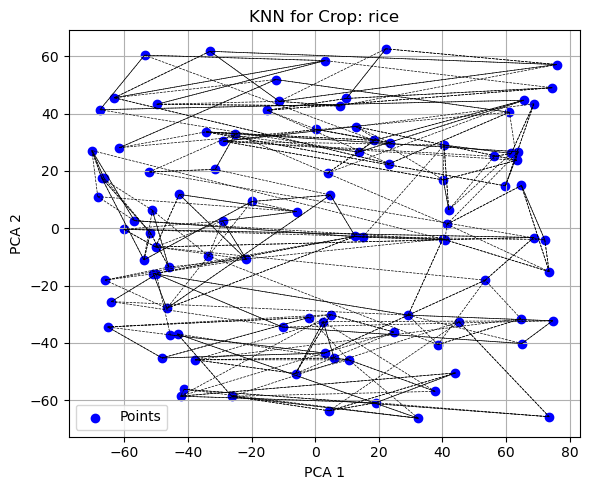

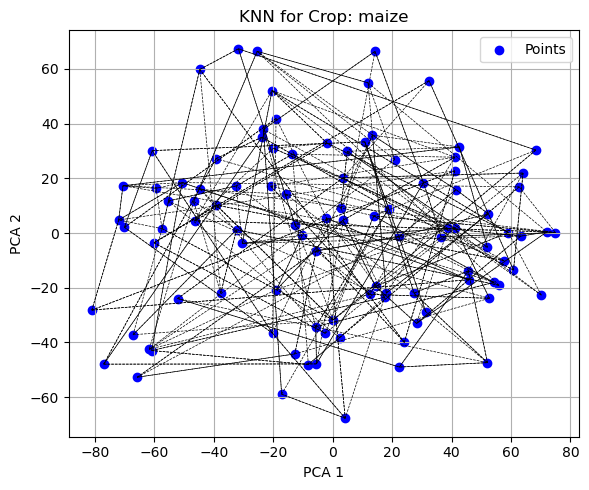

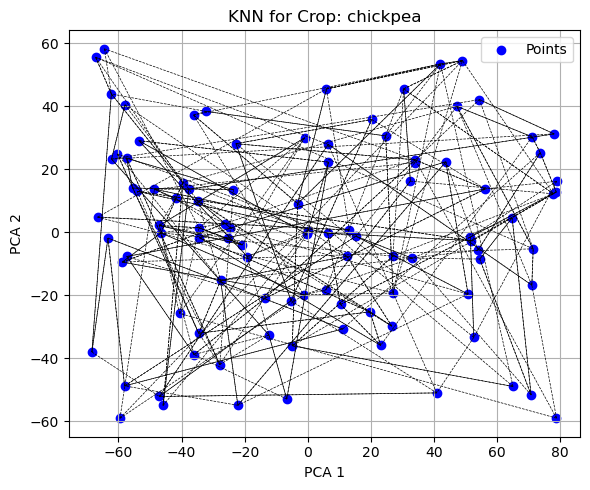

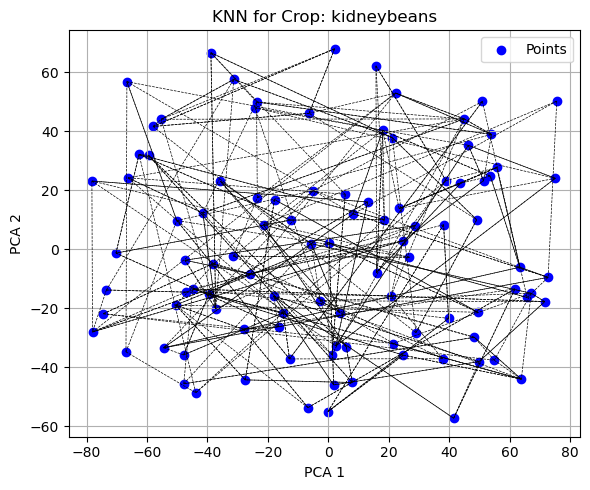

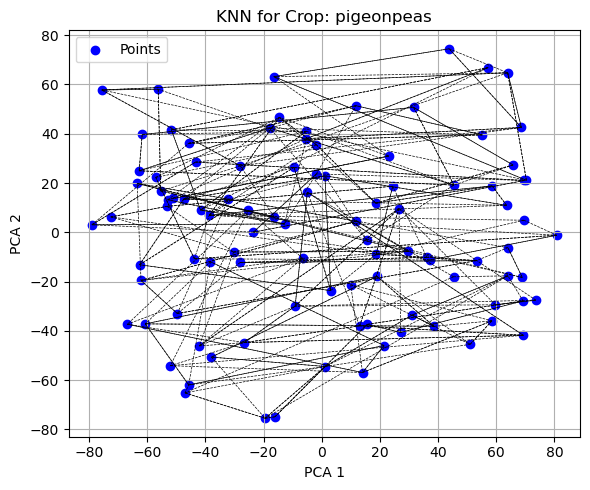

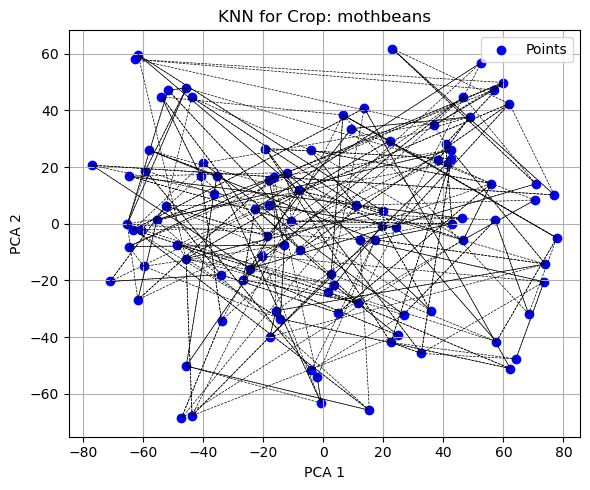

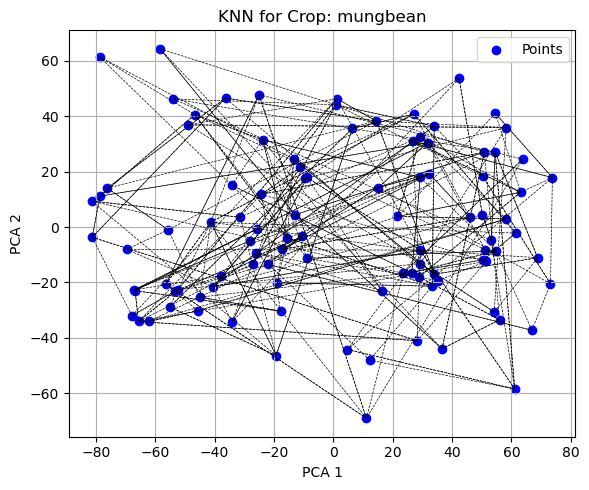

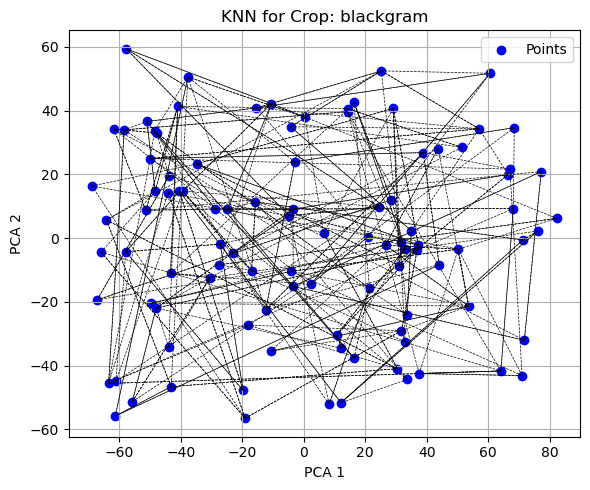

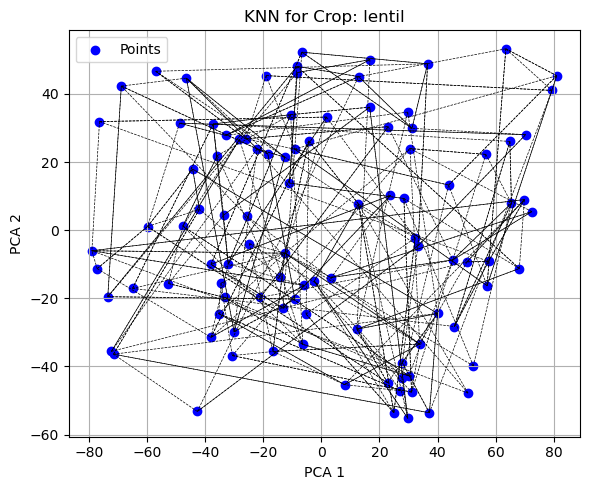

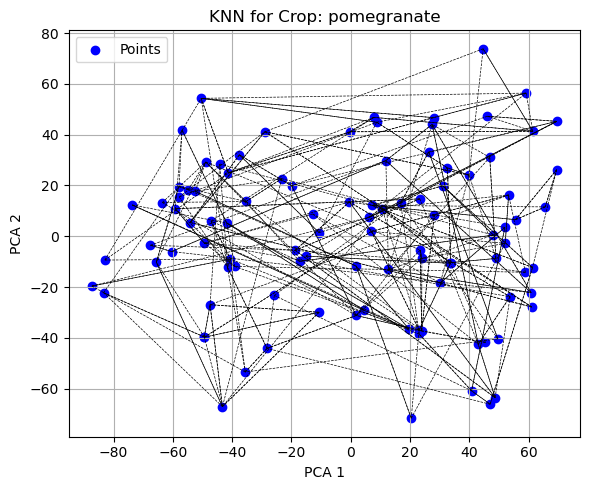

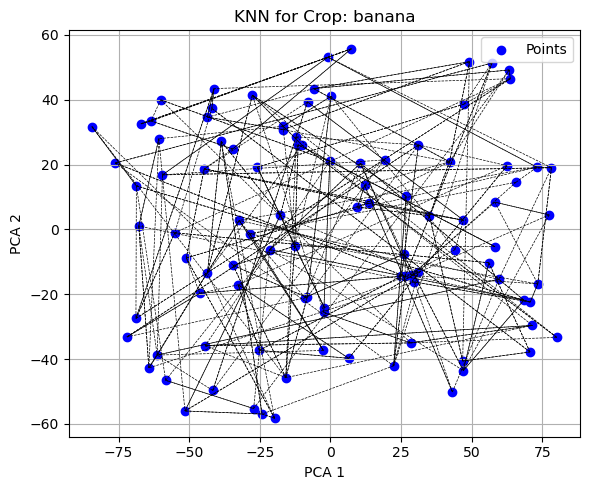

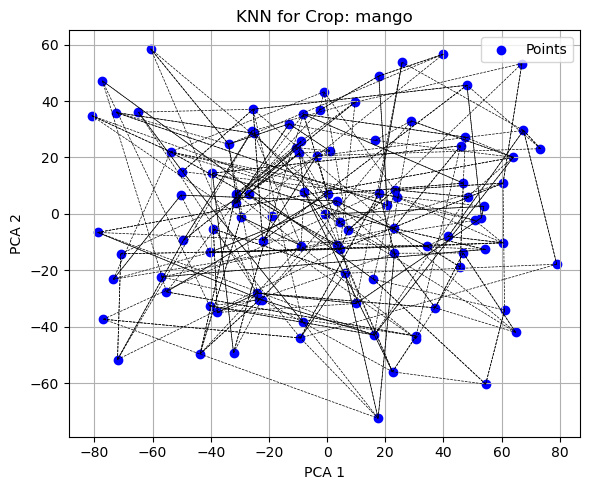

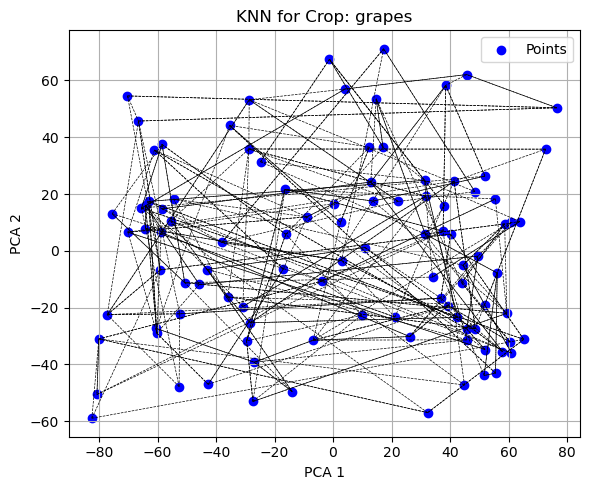

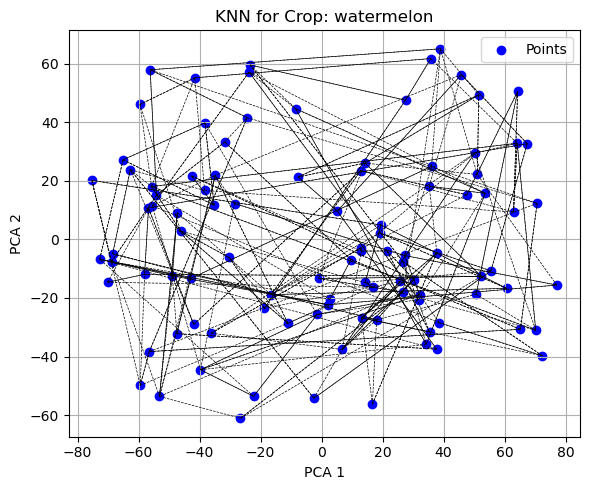

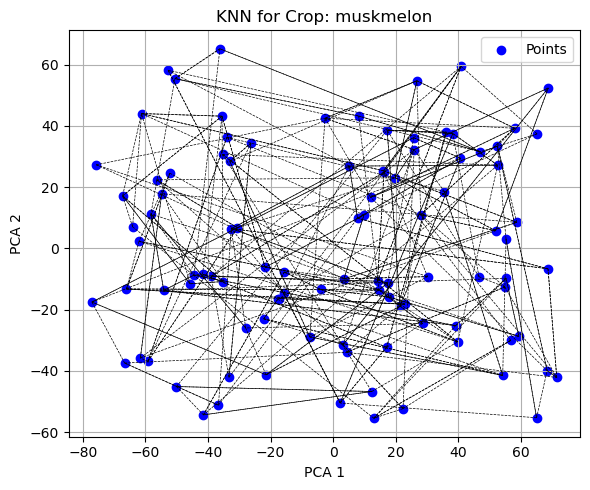

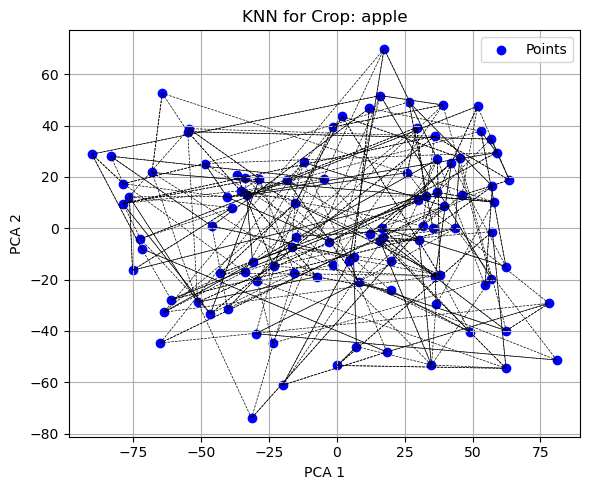

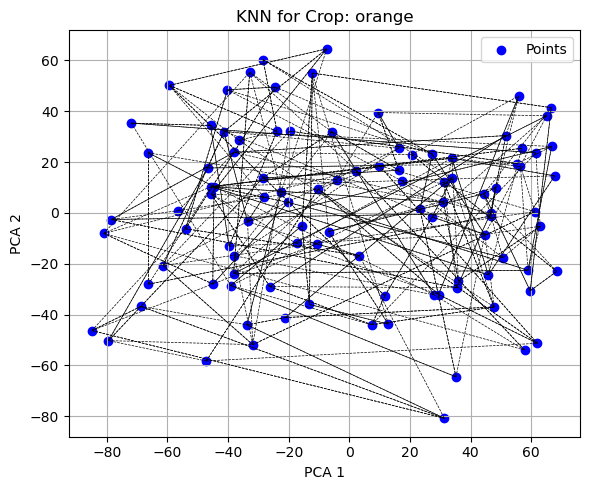

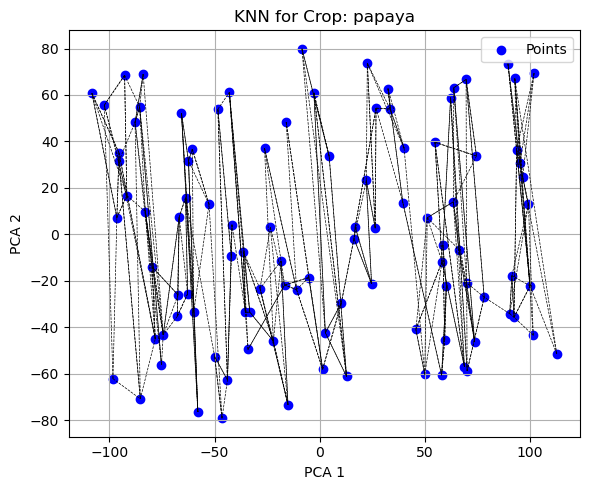

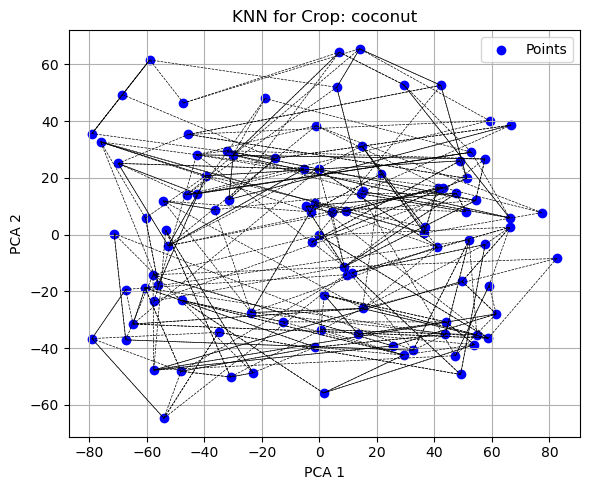

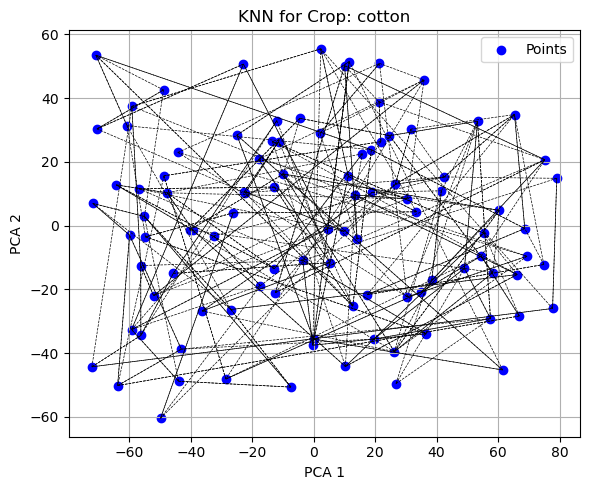

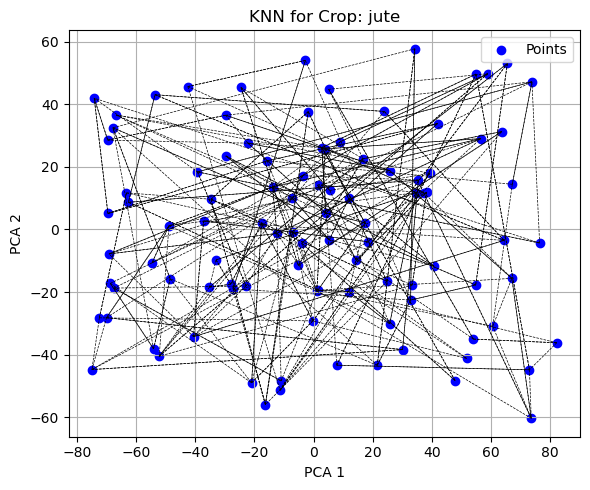

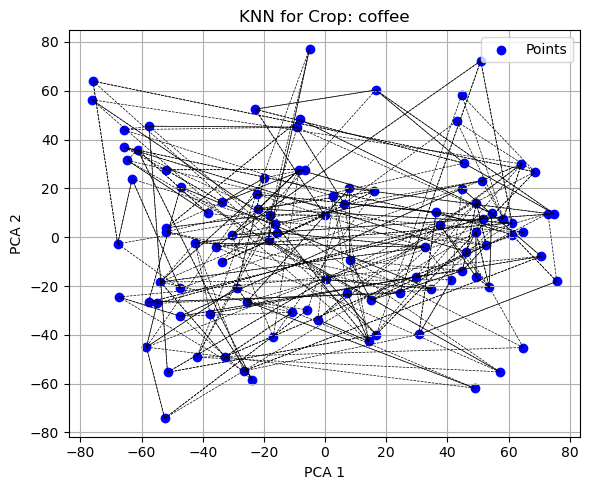

In [78]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def plot_knn_from_models(knn_models):
    """
    Plot KNN neighborhoods from trained models without needing original environments.

    Args:
    - knn_models (dict): Trained NearestNeighbors models per crop type.
    """
    for crop_type, knn in knn_models.items():
        try:
            X = knn._fit_X  # Access stored training data (not officially public)
        except AttributeError:
            print(f"Model for {crop_type} has no stored data. Skipping.")
            continue

        if len(X) < 2:
            continue  # Not enough points to visualize

        # Reduce to 2D for plotting
        pca = PCA(n_components=2)
        X_2d = pca.fit_transform(X)

        # Get neighbors
        neighbors = knn.kneighbors(return_distance=False)

        # Plot
        plt.figure(figsize=(6, 5))
        plt.title(f"KNN for Crop: {crop_type}")
        plt.scatter(X_2d[:, 0], X_2d[:, 1], color='blue', label='Points')

        # Draw neighbor lines
        for i, nbrs in enumerate(neighbors):
            for j in nbrs:
                if i != j:
                    plt.plot([X_2d[i, 0], X_2d[j, 0]], [X_2d[i, 1], X_2d[j, 1]], 'k--', linewidth=0.5)

        plt.xlabel("PCA 1")
        plt.ylabel("PCA 2")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

# Now, plotting the KNN models from the `problem` object
for crop_type, knn in problem.knn_models.items():
    plot_knn_from_models({crop_type: knn})  # Pass each model as a dictionary